In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
import warnings

In [91]:
warnings.filterwarnings('ignore')  # Ignores all warnings
# Load the data
data_path = '../Data/cirrhosis_clean.csv'
data = pd.read_csv(data_path)
# Display the first few rows of the dataframe to understand its structure
data.head()

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
0,1,-1.432360,0.827904,2.485914,-0.491215,-2.194559,0.684867,-0.123847,0.271931,0.764998,-0.757816,1.470371,1.104369,0,0,0,0,0,0,0
1,2,2.223526,0.608395,-0.476689,-0.305613,1.478942,-0.512297,2.532642,-0.159629,-0.593622,-0.430953,-0.125301,-0.036569,1,0,0,1,0,0,1
2,3,-0.886652,1.898239,-0.410362,-0.876001,-0.095416,1.318660,-0.686329,-0.467356,-1.127366,-1.169029,1.270912,1.104369,0,0,1,1,1,1,2
3,4,-0.072549,0.446938,-0.321927,-0.568172,-2.337683,-0.394928,1.936935,-1.093939,-0.528926,-0.831623,-0.424490,1.104369,0,0,0,1,0,0,2
4,5,-0.447946,-1.127724,0.031817,-0.409731,0.023854,0.532288,-0.613796,-0.166165,-0.852407,-1.327189,0.173887,-0.036569,2,1,0,1,0,0,1


In [92]:
# Separate the features and the target variable
X = data.drop(['ID', 'Status'], axis=1)
y = data['Status']

# Split the data into train+validation (85%) and test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Split the train+validation into train (70%) and validation (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 of 85% is approximately 15% of the whole

# Check the size of each set to confirm the split ratio
len(X_train), len(X_val), len(X_test)

(218, 47, 47)

In [93]:
# Training the decision tree with different hyperparameters
best_tree = None
accuracy_depth_train = []
accuracy_depth_val = []
accuracy_depth_test = []
prev_val_accuracy = 0  # Store the previous validation accuracy
condition_met_once = False  # Track if the condition has been met once already

for depth in range(1, 30):  # Exploring different depths
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42, criterion="gini")
    tree.fit(X_train, y_train)
    
    # Calculate accuracies
    train_accuracy = tree.score(X_train, y_train)
    val_accuracy = tree.score(X_val, y_val)
    test_accuracy = tree.score(X_test, y_test)
    
    accuracy_depth_train.append(train_accuracy)
    accuracy_depth_val.append(val_accuracy)
    accuracy_depth_test.append(test_accuracy)
    
    # Check if the current validation accuracy difference from the previous one is within 5%
    if depth > 1 and abs(val_accuracy - prev_val_accuracy) <= 0.05 and best_tree is None:
        if condition_met_once:
            best_tree = tree  # Update the best model
        else:
            condition_met_once = True  # First time condition is met
    else:
        condition_met_once = False  # Reset the condition flag if not met

    prev_val_accuracy = val_accuracy  # Update the previous validation accuracy

In [94]:
if best_tree is not None:
    # Calculate test accuracy of the best tree
    test_accuracy = best_tree.score(X_test, y_test)
    # Access the max_depth attribute of the best tree
    tree_depth = best_tree.max_depth
    print("Test Accuracy of the best tree:", test_accuracy)
    print("Depth of the best tree:", tree_depth)
else:
    print("No suitable tree was found.")

Test Accuracy of the best tree: 0.6808510638297872
Depth of the best tree: 6


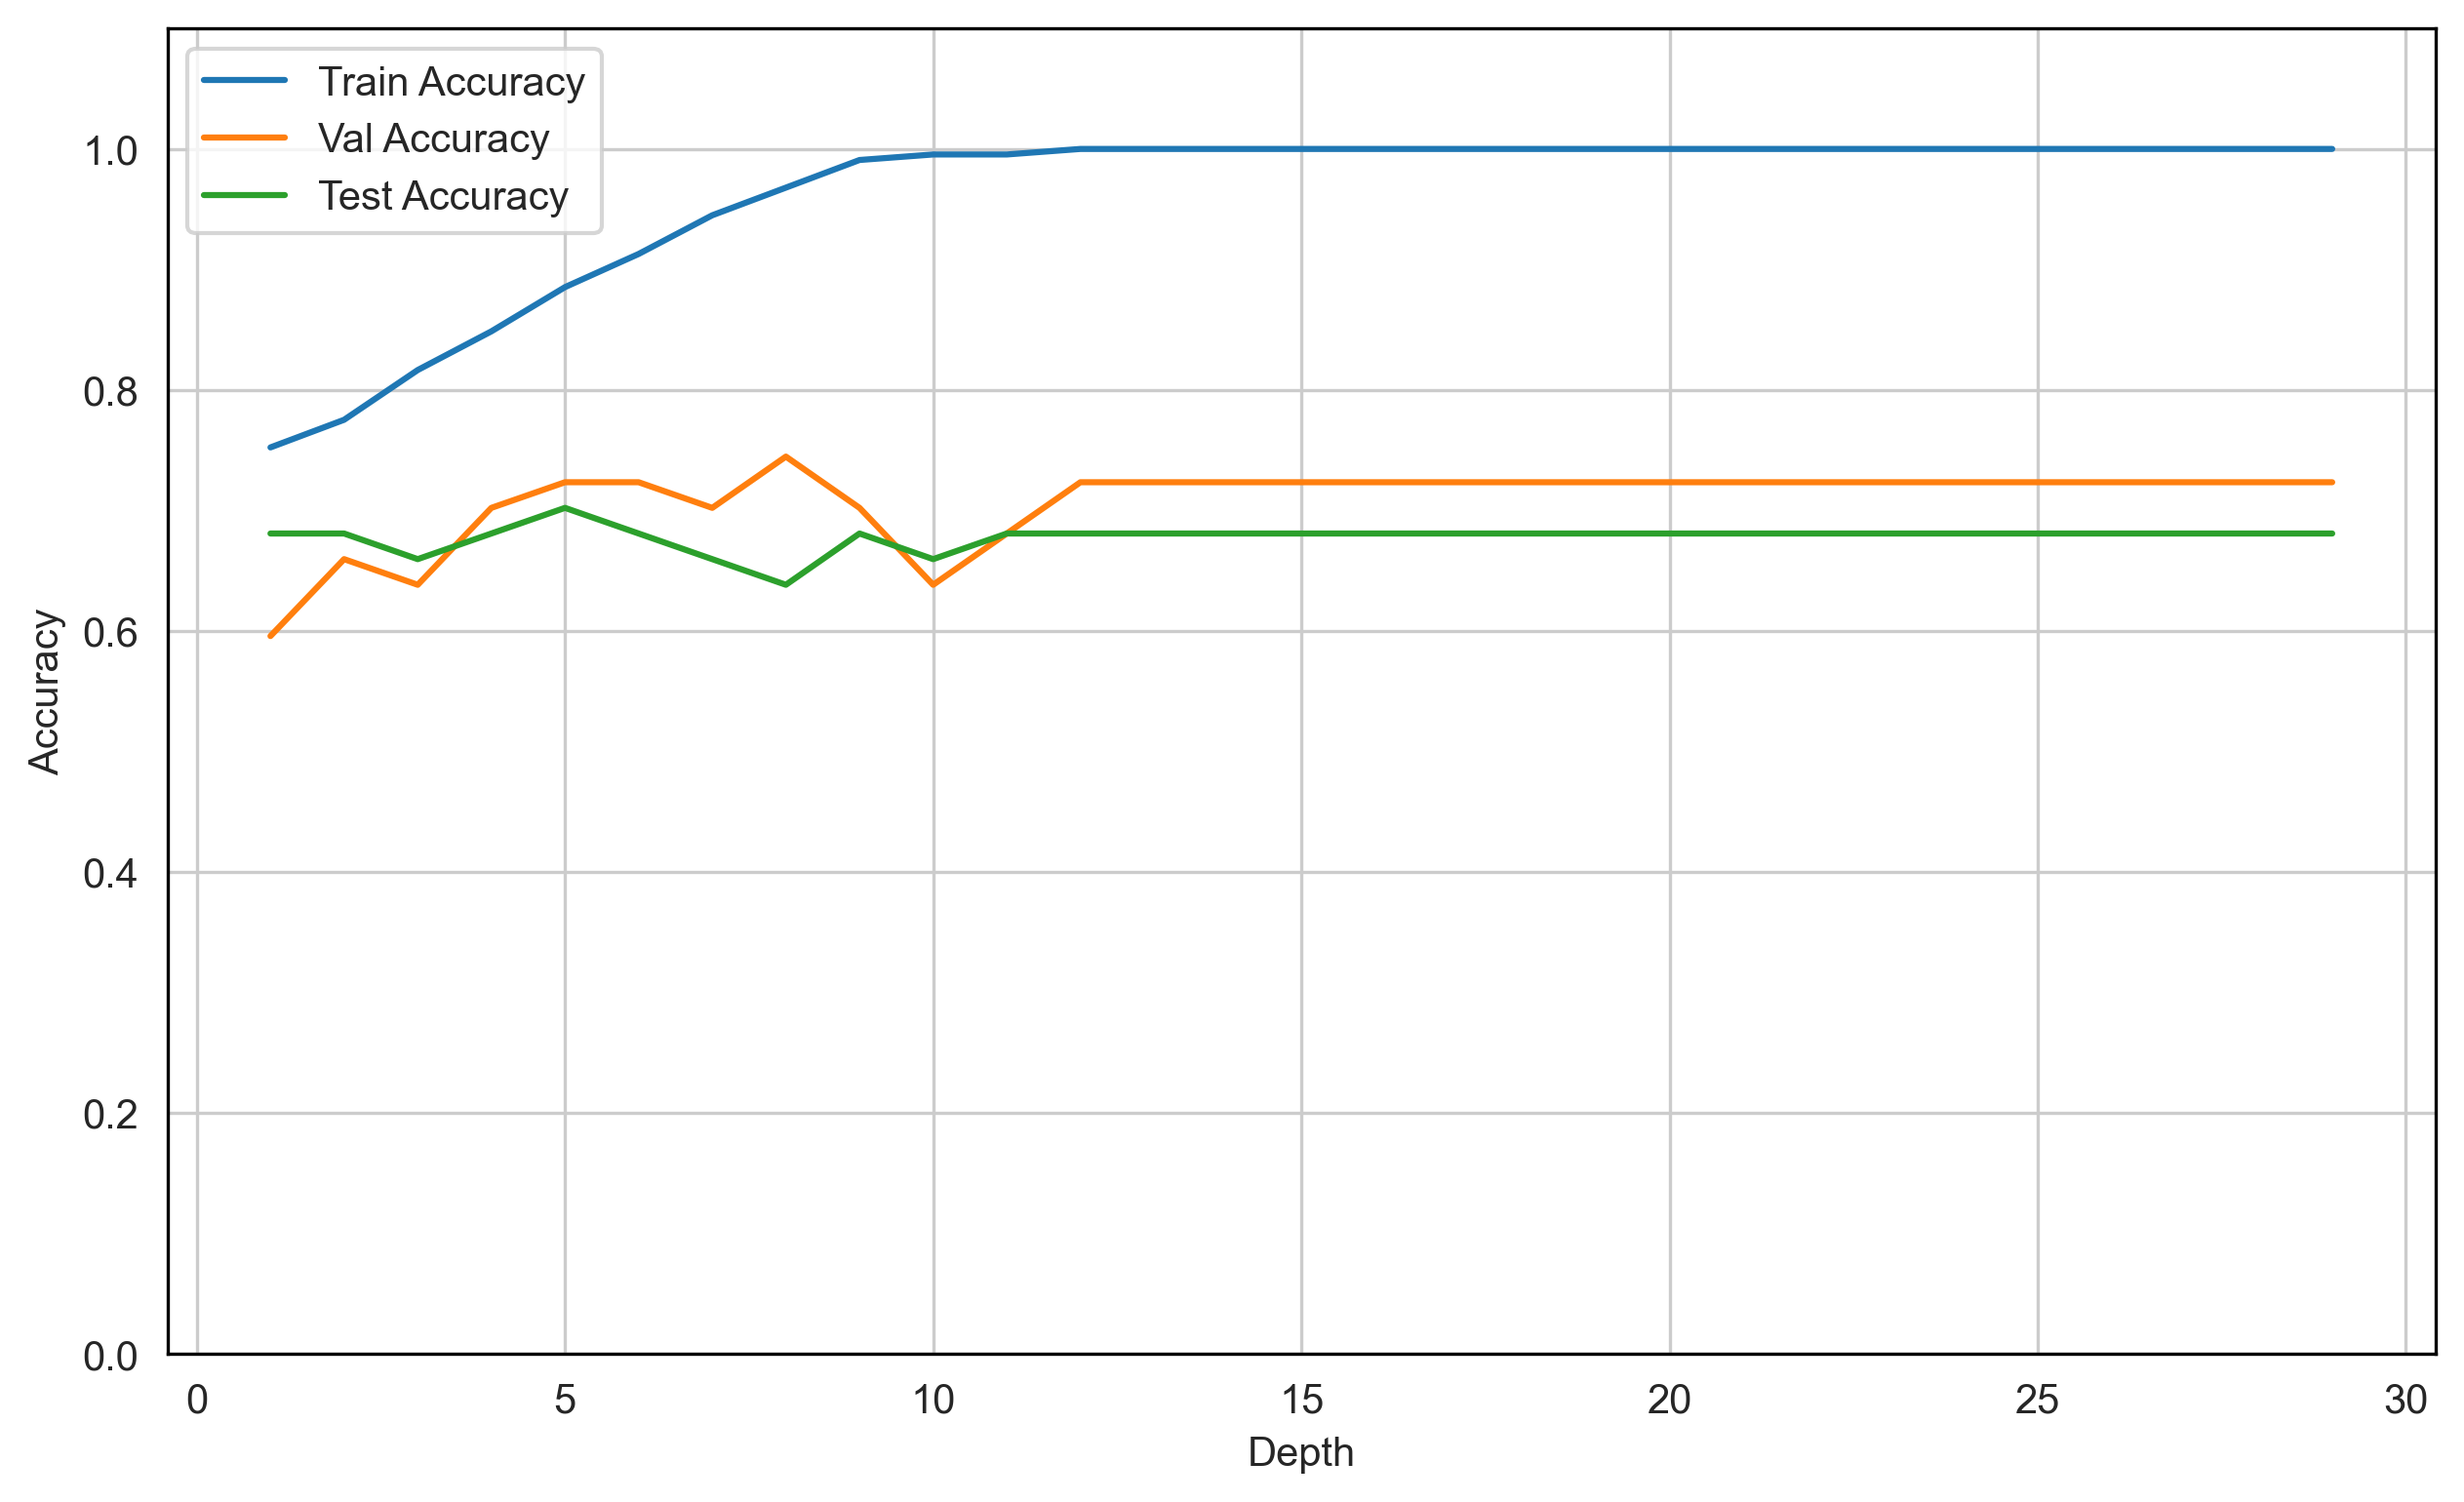

In [95]:
# Creating one plot with three lines
plt.figure(figsize=(10, 6), dpi=300)  
plt.plot(range(1, 30), accuracy_depth_train, label='Train Accuracy')
plt.plot(range(1, 30), accuracy_depth_val, label='Val Accuracy')
plt.plot(range(1, 30), accuracy_depth_test, label='Test Accuracy')

plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1.1)  # Setting the y-axis from 0 to 1

ax = plt.gca()  
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
plt.show()

In [96]:
# Define the parameter grid
param_grid = {
    'pca__n_components': [1, 2, 3, 4, 5],
    'decisiontreeclassifier__max_depth': [3, 4, 5, 6, 8, 10],
    'decisiontreeclassifier__min_samples_split': [1, 2, 3, 4, 5],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 3, 4, 5],
    'decisiontreeclassifier__max_features': [None, 'sqrt', 'log2'],
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('pca', PCA()),
    ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42))
])

# Create the grid search object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_val, y_train_val)

# Print the best parameters and the best score
print('Best parameters:', grid_search.best_params_)
print('Best cross-validation score: {:.4f}'.format(grid_search.best_score_))

# Evaluate the model on the test set
test_accuracy = grid_search.score(X_test, y_test)
print('Test set accuracy: {:.4f}'.format(test_accuracy))

Fitting 5 folds for each of 4500 candidates, totalling 22500 fits
Best parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 4, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 3, 'decisiontreeclassifier__min_samples_split': 2, 'pca__n_components': 1}
Best cross-validation score: 0.7623
Test set accuracy: 0.6809


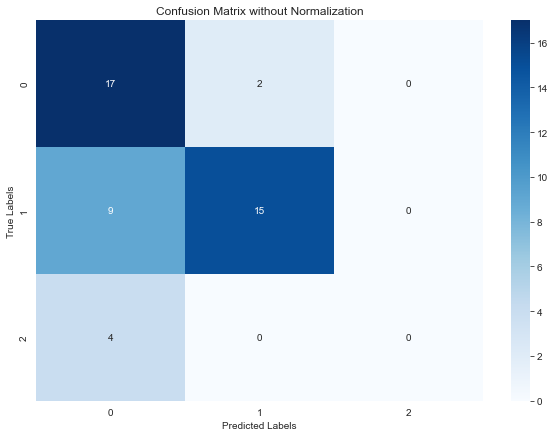

In [97]:
# Predict the responses for the test set
y_pred = grid_search.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [98]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)  
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.82
Recall: 0.51
F1-Score: 0.48


In [99]:
# Get the probability estimates for the test set
prob_predictions = grid_search.predict_proba(X_test)

# Calculate the log loss
logloss = log_loss(y_test, prob_predictions)

print(f"Log Loss: {logloss:.4f}")

Log Loss: 2.1330


In [100]:
# Training the random forest with different hyperparameters
best_forest = None
accuracy_depth_train = []
accuracy_depth_val = []
accuracy_depth_test = []
prev_val_accuracy = 0  # Store the previous validation accuracy
condition_met_once = False  # Track if the condition has been met once already

for depth in range(1, 30):  # Exploring different depths
    forest = RandomForestClassifier(max_depth=depth, random_state=42, criterion="gini", n_estimators=100)
    forest.fit(X_train, y_train)
    
    # Calculate accuracies
    train_accuracy = forest.score(X_train, y_train)
    val_accuracy = forest.score(X_val, y_val)
    test_accuracy = forest.score(X_test, y_test)
    
    accuracy_depth_train.append(train_accuracy)
    accuracy_depth_val.append(val_accuracy)
    accuracy_depth_test.append(test_accuracy)
    
    # Check if the current validation accuracy difference from the previous one is within 5%
    if depth > 1 and abs(val_accuracy - prev_val_accuracy) <= 0.05 and best_forest is None:
        if condition_met_once:
            best_forest = forest  # Update the best model
        else:
            condition_met_once = True  # First time condition is met
    else:
        condition_met_once = False  # Reset the condition flag if not met

    prev_val_accuracy = val_accuracy  # Update the previous validation accuracy

In [101]:
if best_forest is not None:
    # Calculate test accuracy of the best forest
    forest_accuracy = best_forest.score(X_test, y_test)
    # Access the max_depth attribute of the best forest
    forest_depth = best_forest.max_depth
    print("Test Accuracy of the best tree:", test_accuracy)
    print("Depth of the best tree:", forest_depth)
else:
    print("No suitable tree was found.")

Test Accuracy of the best tree: 0.7872340425531915
Depth of the best tree: 3


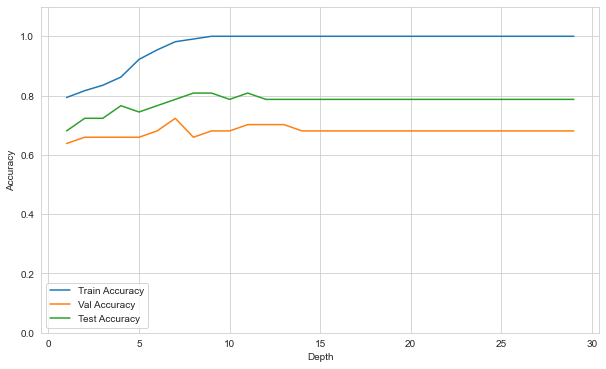

In [102]:
# Creating one plot with three lines
plt.figure(figsize=(10, 6))  
plt.plot(range(1, 30), accuracy_depth_train, label='Train Accuracy')
plt.plot(range(1, 30), accuracy_depth_val, label='Val Accuracy')
plt.plot(range(1, 30), accuracy_depth_test, label='Test Accuracy')

plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1.1)  # Setting the y-axis from 0 to 1

plt.show()

In [103]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'pca__n_components': [3, 4, 5],
    'randomforestclassifier__max_depth': [2, 3, 4, 5, 6, 7],
    'randomforestclassifier__min_samples_split': [1, 2, 3],
    'randomforestclassifier__min_samples_leaf': [1, 2, 3],
    'randomforestclassifier__max_features': [None],
    'randomforestclassifier__criterion': ['gini'],
}

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('pca', PCA()),  # PCA step
    ('randomforestclassifier', RandomForestClassifier(random_state=42))  # Use RandomForestClassifier
])

# Create the grid search object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_val, y_train_val)

# Print the best parameters and the best score
print('Best parameters:', grid_search.best_params_)
print('Best cross-validation score: {:.4f}'.format(grid_search.best_score_))

# Evaluate the model on the test set
test_accuracy = grid_search.score(X_test, y_test)
print('Test set accuracy: {:.4f}'.format(test_accuracy))


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'pca__n_components': 3, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2}
Best cross-validation score: 0.7698
Test set accuracy: 0.6809


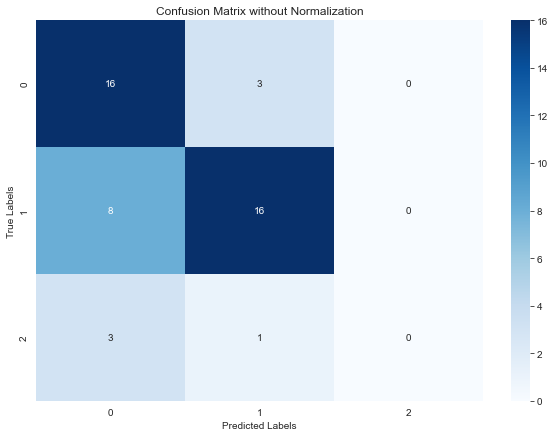

In [104]:
# Predict the responses for the test set
y_pred = grid_search.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [105]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)  
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.80
Recall: 0.50
F1-Score: 0.47


In [106]:
# Get the probability estimates for the test set
prob_predictions = grid_search.predict_proba(X_test)

# Calculate the log loss
logloss = log_loss(y_test, prob_predictions)

print(f"Log Loss: {logloss:.4f}")

Log Loss: 0.7411
